<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Log" data-toc-modified-id="Log-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Log</a></span></li></ul></li><li><span><a href="#Pickle" data-toc-modified-id="Pickle-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pickle</a></span><ul class="toc-item"><li><span><a href="#Everything" data-toc-modified-id="Everything-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Everything</a></span></li><li><span><a href="#Subset" data-toc-modified-id="Subset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Subset</a></span></li></ul></li><li><span><a href="#DataLoaders" data-toc-modified-id="DataLoaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DataLoaders</a></span></li><li><span><a href="#Model-&amp;-Loss-Function" data-toc-modified-id="Model-&amp;-Loss-Function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model &amp; Loss Function</a></span><ul class="toc-item"><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Working-with-a-batch" data-toc-modified-id="Working-with-a-batch-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Working with a batch</a></span></li><li><span><a href="#Make-anchors" data-toc-modified-id="Make-anchors-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Make anchors</a></span></li><li><span><a href="#IOU" data-toc-modified-id="IOU-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>IOU</a></span></li></ul></li></ul></div>

## Log

Video: https://www.youtube.com/watch?v=0frKXR-2PBY

- 2020-10-27 (Tues): Started implementing Jeremy's solution w/ anchor boxes in 2018.9. Made progress. Left off video at 57:49.

# Pickle

## Everything

In [ ]:
# from fastai.vision.all import *

# # paths
# path = Path('/home/rory/data/coco2017')
# train_im_dir, valid_im_dir = 'train2017', 'val2017'
# train_json = 'annotations/instances_train2017.json'
# valid_json = 'annotations/instances_val2017.json'
# animals = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']

# # get items & annos
# def get_annos(path, anno_file, im_folder):
#     xs, ys = get_annotations(path/anno_file)
#     return L(xs).map(lambda x: path/im_folder/x), ys
# train_paths, train_annos = get_annos(path, train_json, train_im_dir)
# valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
# paths  = train_paths + valid_paths
# annos  = train_annos + valid_annos
# bboxes = [a[0] for a in annos]
# lbls   = [a[1] for a in annos]

# # create df and pkl
# df = pd.DataFrame({
#     "path": paths,
#     "lbl":  lbls,
#     "bbox": bboxes,
#     "is_valid": [0]*len(train_files) + [1]*len(valid_files),
#     "n_items": L(len(l) for l in lbls)
#     })
# df.to_pickle(path/'20201027_coco_df.pkl')

# df.head(1)

## Subset

In [ ]:
from fastai.vision.all import *

def make_subset_pkl():
    
    # paths
    path = Path('/home/rory/data/coco2017')
    train_im_dir, valid_im_dir = 'train2017', 'val2017'
    train_json = 'annotations/instances_train2017.json'
    valid_json = 'annotations/instances_val2017.json'
    animals = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']

    # get items & annos
    def get_annos(path, anno_file, im_folder):
        xs, ys = get_annotations(path/anno_file)
        return L(xs).map(lambda x: path/im_folder/x), ys
    train_files, train_annos = get_annos(path, train_json, train_im_dir)
    valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
    annos = train_annos + valid_annos
    bboxes = L(L(b) for b,l in annos)
    lbls   = L(L(l) for b,l in annos)

    # get label subset
    def flatten(l):
        def _recur(l,res):
            for o in l:
                if   isinstance(o,list): _recur(o,res)
                elif isinstance(o,L)   : _recur(o,res)
                else: res.append(o)
            return res
        return _recur(l, L())
    lbls_flat = flatten(lbls)
    def get_count(lbl): return len(lbls_flat.filter(lambda x: x==lbl))
    lbls_sorted = sorted(lbls_flat.unique(), key=get_count, reverse=True)
    lbl_cts = [(l, get_count(l)) for l in lbls_sorted]
    lbl_ss = [l for l,c in lbl_cts if 5000<c<30000]
    lbl_ss.remove('traffic light')
    lbl_ss.remove('motorcycle')
    lbl_ss.remove('bus')

    # get subset items & annos
    ss_idxs   = L(L(o in lbl_ss for o in l) for l in lbls)
    ss_lbls   = L(o[i] for o,i in zip(lbls,ss_idxs))
    ss_bboxes = L(o[i] for o,i in zip(bboxes,ss_idxs))
    ss_obj    = L(len(l) for l in ss_lbls)
    
    # create df
    df = pd.DataFrame({
        "path"  : train_files + valid_files,
        "lbl"   : ss_lbls,
        "bbox"  : ss_bboxes,
        "n_obj" : ss_obj
        })

    # remove rows w/ 4+ objects per im
    # reduce value counts to a max of 2*min_vc
    too_many = 4
    rng = list(range(too_many))
    cts = list(df['n_obj'].value_counts())[:too_many]
    minv = min(cts)
    zipd = list(zip(*[rng,cts]))
    zipd[0] = (0, minv) # limit ims w/zero objs
    df = pd.concat([df[df['n_obj']==i].sample(n=min(s,minv*2)) for i,s in zipd])

    # create pkl
    df.to_pickle(path/'20201029_coco_ss_df.pkl')

In [ ]:
# make_subset_pkl()

# DataLoaders

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
path       = Path('/home/rory/data/coco2017')
valid_pct  = .10


### Items ###
df = pd.read_pickle(path/'20201029_coco_ss_df.pkl')
# get items
def get_cols(df,cols): return L(L(df[c].to_list()) for c in cols)
paths, bboxes, lbls  = get_cols(df, ['path', 'bbox', 'lbl'])
p2b = {p:b for p,b in zip(paths,bboxes)}
p2l = {p:l for p,l in zip(paths,lbls)}
def get_bbox(p): return p2b[p]
def get_lbl(p):  return p2l[p]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths)
print("Training n:",int(len(df)*(1-valid_pct)))

Training n: 56857


# Model & Loss Function

## Model Architecture

In [ ]:
# anchor params
k = 1
anc_grid = 4

In [ ]:
# 42:33
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [ ]:
# 42:33
def flatten_conv(x,k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2) # loss expects flat tensor

In [ ]:
# 42:33
class OutConv(nn.Module):
    # output is two conv layers (instead of one linear layer)
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [ ]:
# 42:00
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

class custom_module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

In [ ]:
head_reg4 = SSD_Head(k, -3.)
body = create_body(resnet34, pretrained=True)
mod = custom_module(body, head_reg4)
learner = Learner(dls, mod)

In [ ]:
### Show ###
def show_bb(im,bb,lbl=None,sz=224,figsize=[5,5],color='white',ctx=None,use_vocab=True):
    bboxes = TensorBBox((bb+1)*sz//2)
    if lbl!=None:
        if use_vocab==True:
            try: label = dls.vocab[lbl]
            except: label = lbl
        else: label = lbl
        lbboxes = LabeledBBox(bboxes, label)
    if ctx==None: ctx=show_image(im, figsize=figsize)
    else: show_image(im, figsize=figsize, ctx=ctx)
    if lbl!=None: lbboxes.show(ctx=ctx) # draw white bboxes and lbls
    bboxes.show(ctx=ctx, color=color) # draw colored bboxes over white bboxes
    return ctx

## Working with a batch

In [ ]:
# 52:00
# grab batch & preds
batch = dls.one_batch()
learner.model.eval()
preds = learner.model(batch[0].cpu())
pred_bboxes, pred_lbls = preds

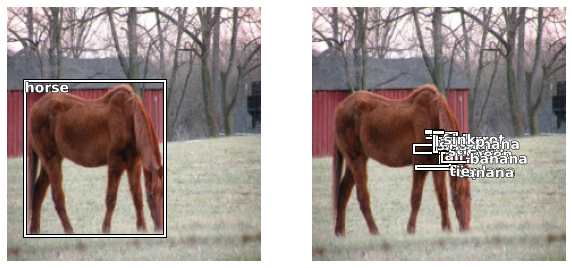

In [ ]:
# grab single im & pred
idx=7
pred_bbox = pred_bboxes[idx]
pred_lbl = pred_lbls[idx]
dec_batch = dls.decode(batch)
dec_im = dec_batch[0][idx]
bbox, lbl = batch[1][idx].cpu(), batch[2][idx].cpu()

# show im & pred
ctx = get_grid(2, figsize=[10,10])
show_bb(dec_im, bbox, lbl, ctx=ctx[0])
show_bb(dec_im, pred_bbox, pred_lbl.max(1)[1], ctx=ctx[1]);

## Make anchors

Anchors are in [x-center, y-center, h, w] format. The following cell converts them to [x-topr, y-topr, x-botl, y-botl] format.

In [ ]:
# 41:43
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_hws = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = torch.cat((tensor(anc_ctrs), tensor(anc_hws)), axis=1)
grid_sizes = tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1) # 0.25

def hw2bb(ctr,hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1

anc_bbs = hw2bb(anc_ctrs, anc_hws)

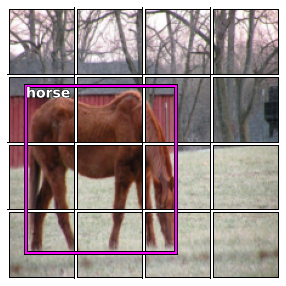

In [ ]:
# show anchorbbs and targbbs together
ctx = show_bb(dec_im, anc_bbs)
show_bb(dec_im, bbox, lbl, ctx=ctx, color='magenta');

## IOU

In [ ]:
# 1:05:36
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def bb_area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_overlaps(b1, b2):
    """Uses IOU (index over union) to calculate bbox overlaps."""
    inter = intersxn(b1,b2)
    union = bb_area(b1).unsqueeze(1) + bb_area(b2).unsqueeze(0) - inter
    return inter / union

In [ ]:
# Get overlaps
# ~58min
overlaps = get_overlaps(bbox,anc_bbox)
overlaps

tensor([[0.0000, 0.1028, 0.1270, 0.0750, 0.0000, 0.1480, 0.1846, 0.1067, 0.0000,
         0.0677, 0.0829, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [ ]:
bb_overlaps = overlaps.max(0)
bb_overlaps # 0 is overloaded – means max overlap at obj index 0 AND overlap is 0

torch.return_types.max(
values=tensor([0.0000, 0.1028, 0.1270, 0.0750, 0.0000, 0.1480, 0.1846, 0.1067, 0.0000,
        0.0677, 0.0829, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
anc_overlaps = overlaps.max(1)
anc_overlaps

torch.return_types.max(
values=tensor([0.1846, 0.0000, 0.0000]),
indices=tensor([6, 0, 0]))

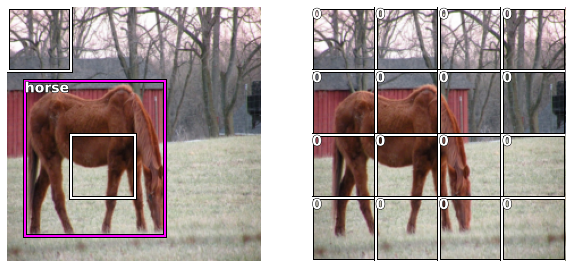

In [ ]:
# Visualize overlaps
# make fig with two axes
ctx = get_grid(2, figsize=[10,10])
# show each object's highest-IOU anchor box
show_bb(dec_im, anc_bbox[anc_overlaps[1]], ctx=ctx[0]) 
show_bb(dec_im, bbox, lbl, color='magenta', ctx=ctx[0])
# label anchor boxes with the idx of the highest-IOU object
show_bb(dec_im, anc_bbox, bb_overlaps[1].tolist(), use_vocab=False, ctx=ctx[1]);

In [ ]:
# 1:04:40
def map_ancs_to_bbs(overlaps):
    _, anc_idxs = overlaps.max(1) # one element per bb (3 total)
    ancs_max_iou, bb_idxs = overlaps.max(0) # one element per anc (16 total)
    ancs_max_iou[anc_idxs] = 1.99 # for each bb, set iou of highest-iou anc even higher.
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return ancs_max_iou, bb_idxs

In [ ]:
max_iou_per_anc, bb_idx = map_ancs_to_bbs(overlaps)
max_iou_per_anc, bb_idx

(tensor([1.9900, 0.1028, 0.1270, 0.0750, 0.0000, 0.1480, 1.9900, 0.1067, 0.0000,
         0.0677, 0.0829, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000]),
 tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
vocab_idx = overlaps.max(1)[1]
vocab_idx

tensor([6, 0, 0])

In [ ]:
targ_lbls = tensor(lbl[bb_idx], dtype=torch.int)  # maybe this is actually targ_lbl?
targ_lbls

tensor([ 0., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
        27., 27.])

In [ ]:
# 1:01:40
thresh = 0.5
assigned = max_iou_per_anc > thresh
assigned_idx = torch.nonzero(assigned).squeeze()
unassigned_idx = torch.nonzero(~assigned).squeeze()
assigned_idx

tensor([0, 6])

In [ ]:
targ_lbls[~assigned] = 0 # set vocab idx of unassigned ancs to 0 ('#na#')
targ_lbls

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])

In [ ]:
# output labels (readable)
dls.vocab[output_lbls]

(#16) ['#na#','#na#','sink','#na#','#na#','#na#','#na#','#na#','#na#','#na#'...]

In [ ]:
# 1:04:40
def acts_to_bb(acts, anchors):
    act_bbs = torch.tanh(acts)
    act_centers = (act_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    act_hws = (act_bbs[:,2:]/2+1) * anchors[:,:2]
    return hw2bb(act_centers, act_hws)

In [ ]:
output_bbs_all = acts_to_bb(pred_bbox, anchors) # jh calls pred_bbox "b_bboxi" (wtf?)
output_bbs_all

tensor([[-0.8460, -0.8649, -0.5808, -0.6082],
        [-0.8704, -0.6017, -0.6071,  0.1601],
        [-0.8342, -0.3849, -0.5910,  0.8821],
        [-0.8617, -0.1158, -0.6240,  1.6127],
        [-0.6116, -0.8479,  0.2139, -0.5979],
        [-0.6033, -0.5802,  0.1512,  0.2013],
        [-0.5589, -0.3970,  0.1262,  1.0216],
        [-0.5701, -0.1674,  0.1079,  1.7088],
        [-0.3688, -0.8599,  0.9396, -0.6015],
        [-0.3851, -0.6115,  0.9270,  0.2299],
        [-0.3245, -0.4059,  0.9455,  0.9772],
        [-0.2998, -0.1307,  0.8904,  1.6478],
        [-0.1581, -0.8662,  1.6520, -0.6123],
        [-0.1257, -0.6476,  1.6088,  0.1545],
        [-0.1582, -0.3697,  1.6606,  0.9184],
        [-0.1026, -0.1191,  1.6210,  1.6190]], grad_fn=<SubBackward0>)

In [ ]:
# output bbs
output_bbs = output_bbs_all[assigned_idx]
output_bbs

tensor([[-0.8460, -0.8649, -0.5808, -0.6082],
        [-0.5589, -0.3970,  0.1262,  1.0216]], grad_fn=<IndexBackward>)

In [ ]:
targ_bbs_all = bbox[bb_idx] # jh calls bb_idx "gt_idx"
targ_bbs = targ_bbs_all[assigned_idx]
loc_loss = ((output_bbs - targ_bbs).abs()).mean()
lbl_loss = F.cross_entropy(pred_lbl, targ_lbls.long())
loc_loss, lbl_loss

(tensor(0.4439, grad_fn=<MeanBackward0>),
 tensor(3.8797, grad_fn=<NllLossBackward>))

In [ ]:
### LEFT OFF 1:03:00

In [ ]:
# 1:04:40
def get_y(bbox, clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

In [ ]:
# 26:09
def bb_hw(b): return np.array(b[1], b[0], b[3]-b[1], b[2]-b[0])

In [ ]:
# 41:41
# mc, id2cat, cat2id, mcs

# 51:53
# val_idxs, mbb, mbbs, df

# 51:58
# x,y , batch, b_clas, b_bb, idx, b_clasi, b_bboxi, ima, bbox, clas